In [2]:
from dataset_generator_2 import Dataset_sat
import numpy as np
from image_utils import standardize
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_bf
from torch.utils.data import DataLoader
import torch
from unet_val_2 import UNet
import torch.backends.cudnn as cudnn
import torch.nn.functional as Fu
import torch.nn as nn
from torch.autograd import Variable

/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# PATH_TEST='../DATA_GHANA/DATASET/120_x_120_8_bands/TEST/'
PATH_TEST='/scratch/SPACENET_DATA_PROCESSED/DATASET/120_x_120_8_bands_pansh/TEST/'
test_size=20



    
test_generator = Dataset_sat.from_root_folder(PATH_TEST,2,max_data_size=100)
test_loader = DataLoader(test_generator, batch_size=test_size,shuffle=True, num_workers=1)
sample_test=next(iter(test_loader))
X_test=sample_test['input']
Y_test=sample_test['groundtruth']
X_test=standardize(X_test)


image 0


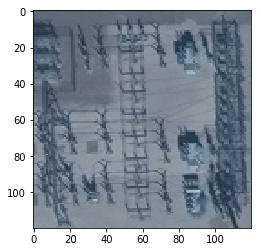

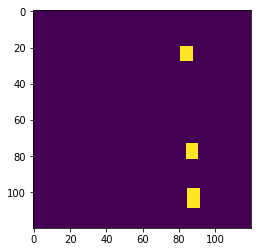

0.0
9.0


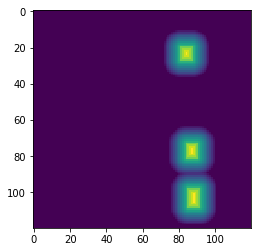

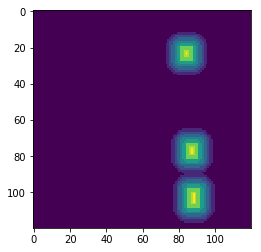

image 1


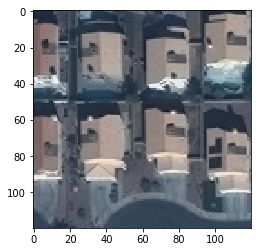

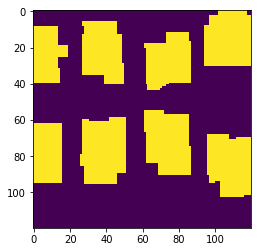

0.0
9.0


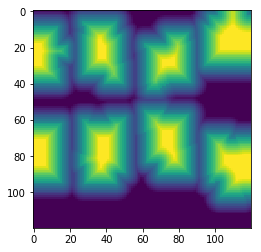

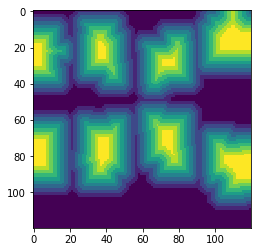

image 2


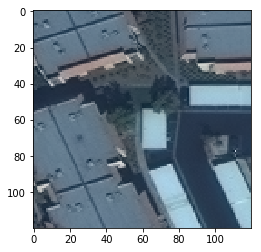

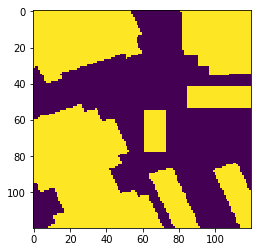

0.0
9.0


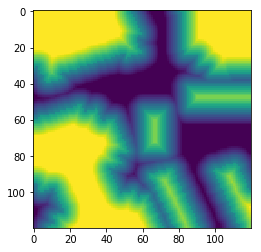

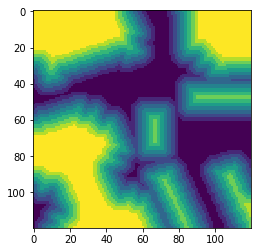

image 3


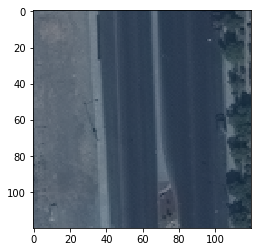

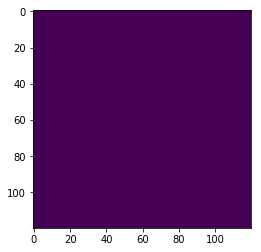

0.0
0.0


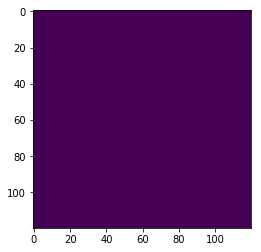

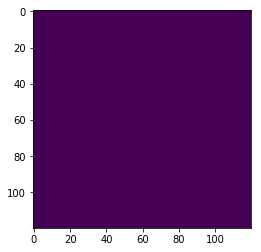

image 4


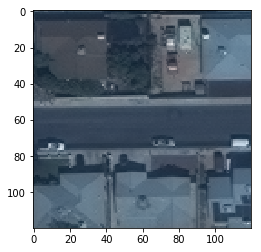

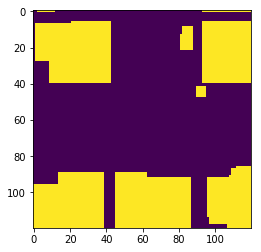

0.0
9.0


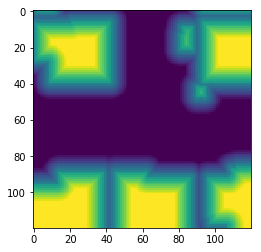

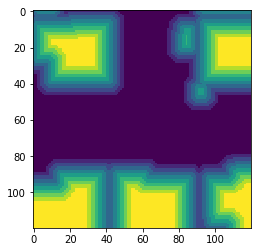

image 5


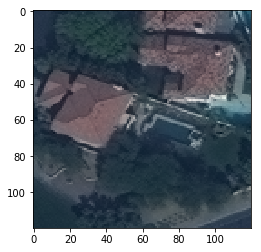

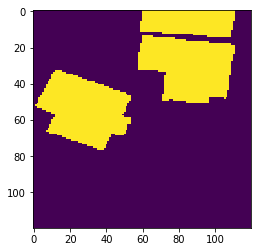

0.0
9.0


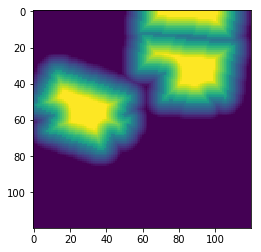

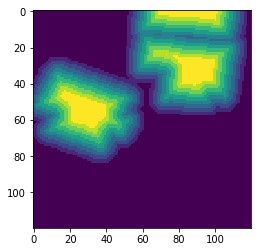

image 6


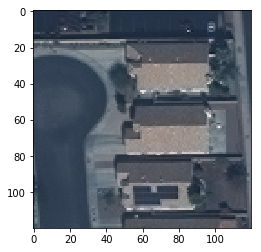

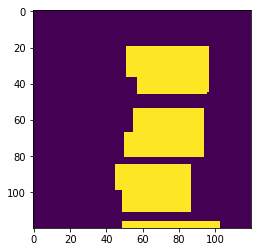

0.0
9.0


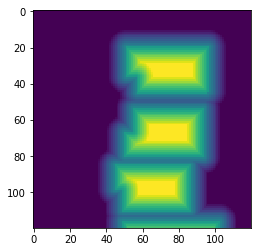

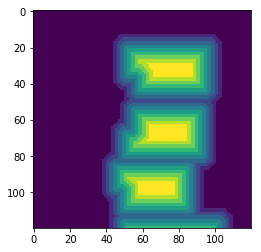

image 7


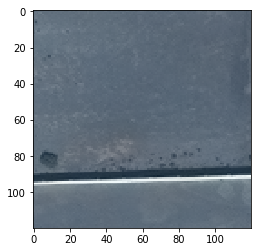

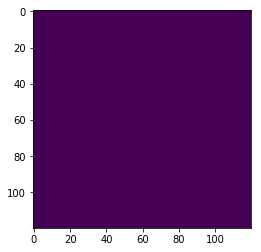

0.0
0.0


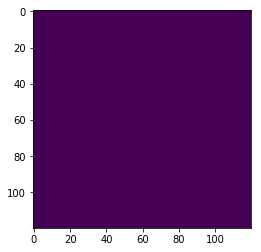

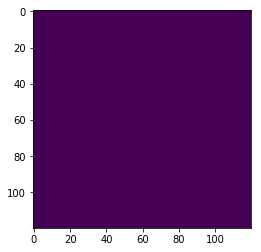

image 8


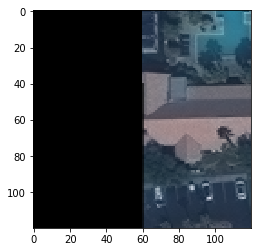

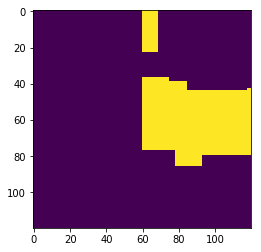

0.0
9.0


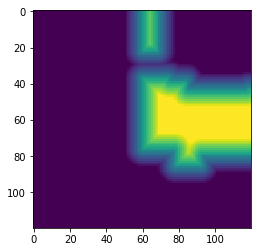

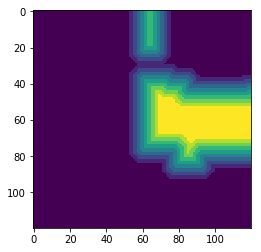

image 9


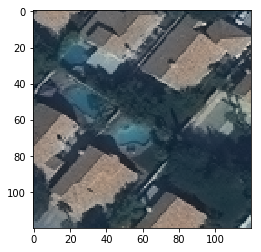

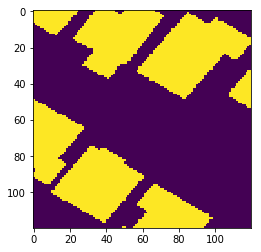

0.0
9.0


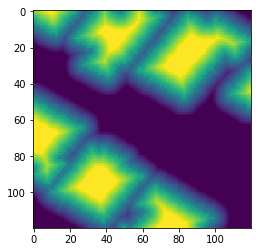

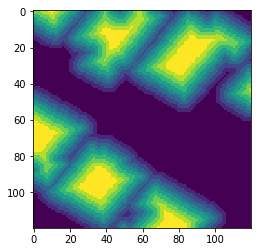

image 10


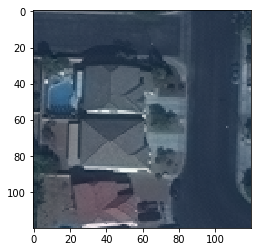

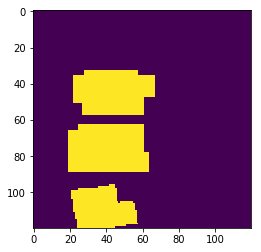

0.0
9.0


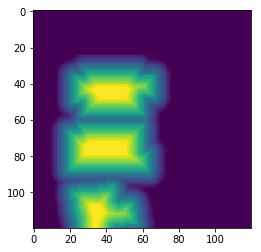

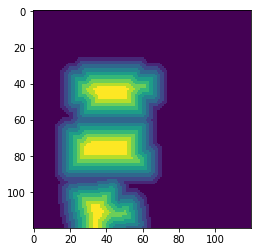

image 11


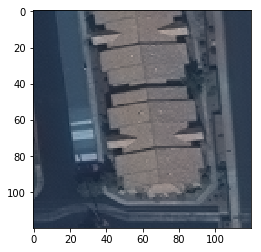

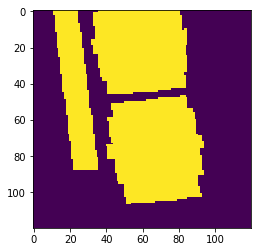

0.0
9.0


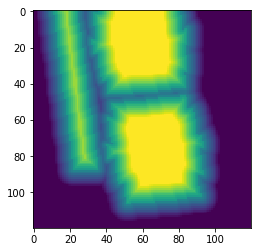

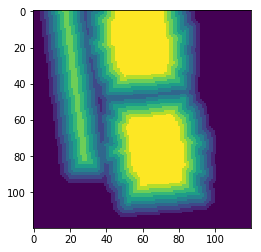

image 12


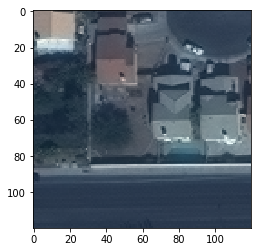

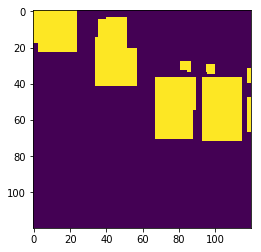

0.0
9.0


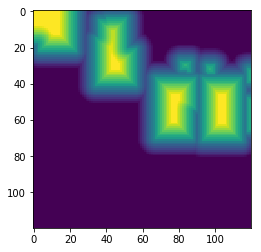

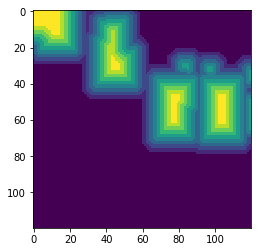

image 13


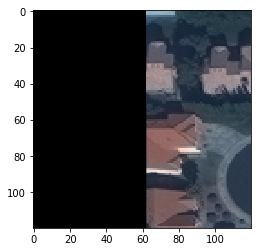

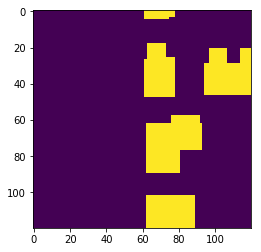

0.0
9.0


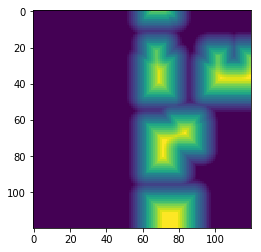

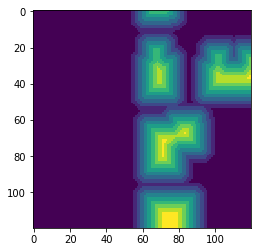

image 14


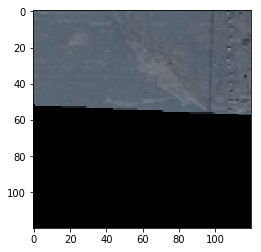

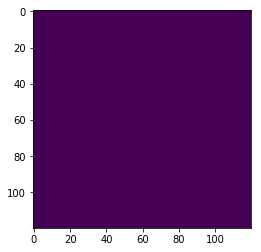

0.0
0.0


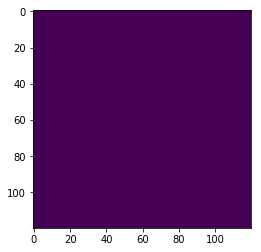

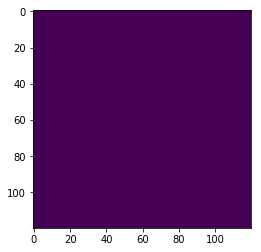

image 15


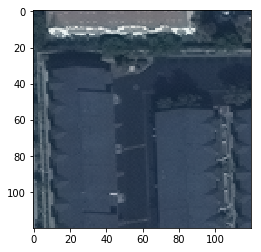

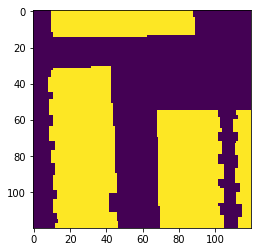

0.0
9.0


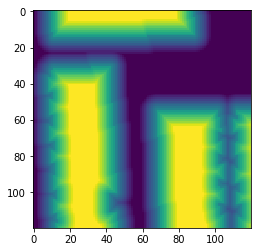

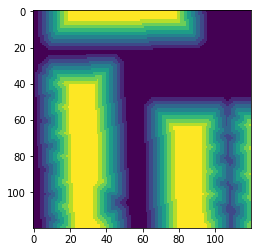

image 16


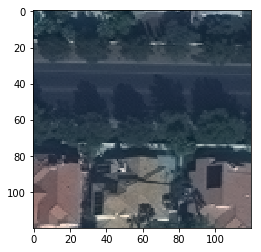

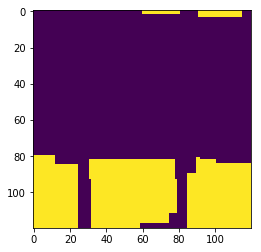

0.0
9.0


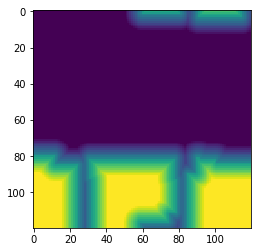

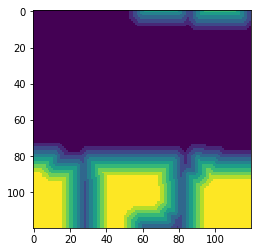

image 17


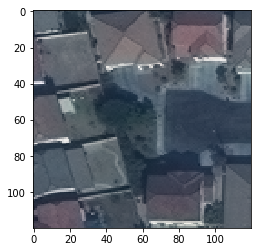

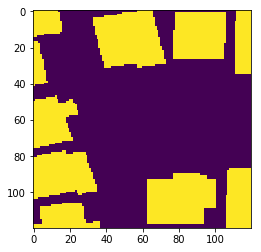

0.0
9.0


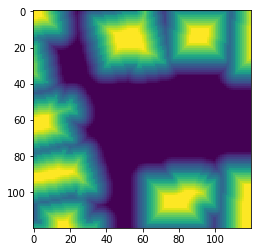

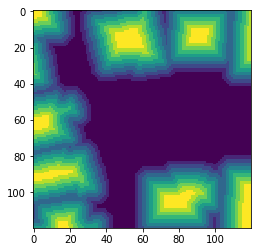

image 18


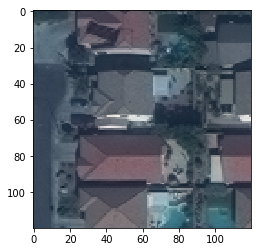

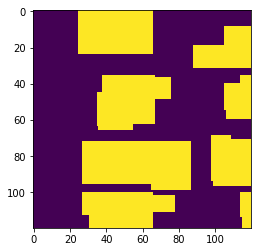

0.0
9.0


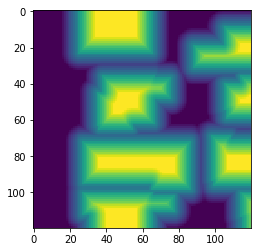

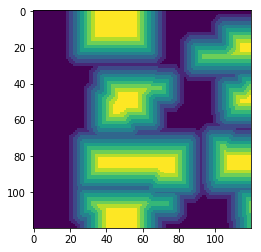

image 19


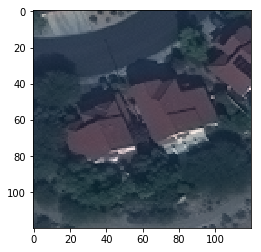

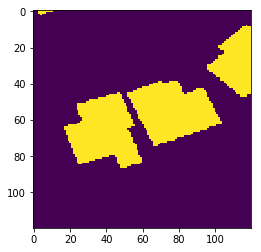

0.0
9.0


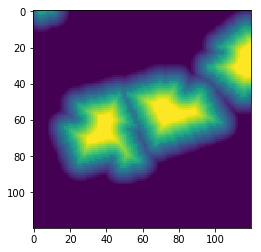

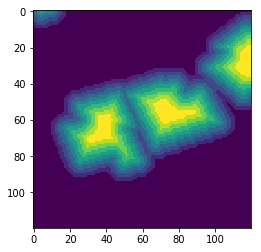

In [53]:
K=10
T=20
##distance map v2 
for i in range(test_size): 
    print('image %d'%i)
    indexes=[5,3,2]
    
    plt.imshow(np.transpose(np.asarray(X_test)[i,:,:,indexes],(1,2,0)))
    plt.show()
    plt.imshow(np.asarray(Y_test)[i,:,:,1])
    plt.show()
    distance_build=distance_transform_bf(np.asarray(Y_test)[i,:,:,1],sampling=2)
    distance_background=distance_transform_bf(np.asarray(Y_test)[i,:,:,0],sampling=2)
    distance_build=np.minimum(distance_build,T*(distance_build>0))
    distance_background=np.minimum(distance_background,T*(distance_background>0))
    distance=(distance_build-distance_background)
    distance=(distance-np.amin(distance))/(np.amax(distance)-np.amin(distance)+1e-50)*(K-1)
    print(np.amin(distance))
    print(np.amax(distance))
    plt.imshow(distance)
    plt.show()


    inp=torch.LongTensor(distance)
    inp_ = torch.unsqueeze(inp, len(distance.shape))
    one_hot = torch.FloatTensor(distance.shape[0], distance.shape[1], K).zero_()
    one_hot.scatter_(len(distance.shape), inp_, 1)
    plt.imshow(np.argmax(one_hot,axis=2))
    plt.show()

In [9]:
def distance_map(Y,threshold=20,bins=15):
    list_one_hot=[]
    for i in range(len(Y)):
        distance=distance_transform_bf(np.asarray(Y_test)[i,:,:,1],sampling=2)
        distance=np.minimum(distance,T*(distance>0))*(K-1)/T
        inp=torch.LongTensor(distance)
        inp_ = torch.unsqueeze(inp, len(distance.shape))
        one_hot = torch.FloatTensor(distance.shape[0],distance.shape[1], K).zero_()
        one_hot.scatter_(len(distance.shape), inp_, 1)
        one_hot=np.asarray(one_hot)
        list_one_hot.append(one_hot)
 
    list_one_hot=np.asarray(list_one_hot)
    return list_one_hot
    

(20, 120, 120, 15)


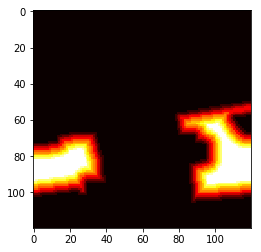

In [21]:
test=distance_map(Y_test)
print(test.shape)
plt.imshow(np.argmax(test[1],axis=2),cmap="hot")
plt.show()

0.7231664061546326


/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


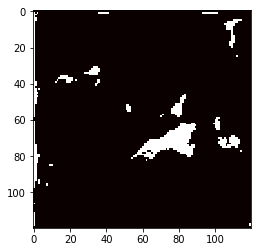

0.7740095853805542


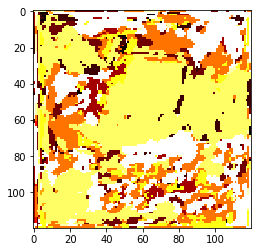

In [7]:

INPUT_CHANNELS=9
NB_CLASSES=2
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DROPOUT=0.9#0.9

model=UNet(INPUT_CHANNELS,NB_CLASSES,DEFAULT_LAYERS,DEFAULT_FEATURES_ROOT,DROPOUT,distance_net=True)
model.cuda()
cudnn.benchmark = True

batch_x=X_val
batch_y=Y_val


X=np.transpose(batch_x, axes=[0,3,1,2])
X = torch.FloatTensor(X)
X = Variable(X).cuda()

Y=np.transpose(batch_y, axes=[0,3,1,2])
Y = torch.FloatTensor(Y)
Y = Variable(Y).cuda()

Y_dist=distance_map(batch_y)
Y_dist=np.transpose(Y_dist, axes=[0,3,1,2])
Y_dist = torch.FloatTensor(Y_dist)
Y_dist = Variable(Y_dist).cuda()

y_pred_dist,y_pred_seg=model(X)
probs_dist = Fu.softmax(y_pred_dist,dim=1)
prob_seg = Fu.softmax(y_pred_seg,dim=1)

loss_dist=Fu.binary_cross_entropy_with_logits(probs_dist,Y_dist)
loss_seg=Fu.binary_cross_entropy_with_logits(prob_seg,Y)

probs_dist=probs_dist.data.cpu().numpy()
probs_dist=np.transpose(probs_dist, axes=[0,2,3,1])

prob_seg=prob_seg.data.cpu().numpy()
prob_seg=np.transpose(prob_seg, axes=[0,2,3,1])

print(loss_dist.data[0])
plt.imshow(np.argmax(prob_seg[2],axis=2),cmap="hot")
plt.show()

print(loss_seg.data[0])
plt.imshow(np.argmax(probs_dist[2],axis=2),cmap="hot")
plt.show()
